In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2D

In [79]:
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, output_dim=1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Reshape((7, 7, 128), input_shape=(128*7*7,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same'))
    model.add(Activation('tanh'))
    return model

In [80]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Flatten, Dropout

In [81]:
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (5, 5), subsample=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [82]:
import math
import numpy as np

In [105]:
def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height = generated_images.shape[1:3]
    combined_image = np.zeros((height*rows, width*cols),
                              dtype=generated_images.dtype)

    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[0, :, :]
    return combined_image

In [106]:
import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

In [107]:
import os
from keras.datasets import mnist
from keras.optimizers import Adam
from PIL import Image

BATCH_SIZE = 32
NUM_EPOCH = 20
GENERATED_IMAGE_PATH = 'generated_images/' # 生成画像の保存先

def train():
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5)/127.5
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])

    discriminator = discriminator_model()
    d_opt = Adam(lr=1e-5, beta_1=0.1)
    discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)

    # generator+discriminator （discriminator部分の重みは固定）
    discriminator.trainable = False
    generator = generator_model()
    dcgan = Sequential([generator, discriminator])
    g_opt = Adam(lr=2e-4, beta_1=0.5)
    dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)

    num_batches = int(X_train.shape[0] / BATCH_SIZE)
    print('Number of batches:', num_batches)
    for epoch in range(NUM_EPOCH):

        for index in range(num_batches):
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = generator.predict(noise, verbose=0)

            # 生成画像を出力
            if index % 500 == 0:
                image = combine_images(generated_images)
                image = image*127.5 + 127.5
                if not os.path.exists(GENERATED_IMAGE_PATH):
                    os.mkdir(GENERATED_IMAGE_PATH)
                Image.fromarray(image.astype(np.uint8))\
                    .save(GENERATED_IMAGE_PATH+"%04d_%04d.png" % (epoch, index))

            # discriminatorを更新
            X = np.concatenate((image_batch, generated_images))
            y = [1]*BATCH_SIZE + [0]*BATCH_SIZE
            d_loss = discriminator.train_on_batch(X, y)

            # generatorを更新
            noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
            g_loss = dcgan.train_on_batch(noise, [1]*BATCH_SIZE)
            print("epoch: %d, batch: %d, g_loss: %f, d_loss: %f" % (epoch, index, g_loss, d_loss))

        generator.save_weights('generator.h5')
        discriminator.save_weights('discriminator.h5')

In [108]:
train()

/Users/mikio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`
  
/Users/mikio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  This is separate from the ipykernel package so we can avoid doing imports until


Number of batches: 1875


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [90]:
generator = generator_model()
BATCH_SIZE = 32
noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
generated_images = generator.predict(noise, verbose=0)

generated_images.shape

/Users/mikio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, units=1024)`
  This is separate from the ipykernel package so we can avoid doing imports until


(32, 28, 28, 1)

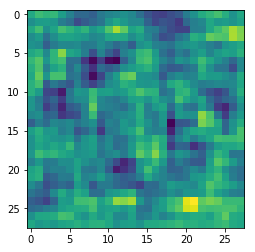

In [92]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.imshow(generated_images[1].reshape(28, 28))

In [93]:
total = generated_images.shape[0]
total

32

In [94]:
cols = int(math.sqrt(total))
cols

5

In [95]:
rows = math.ceil(float(total)/cols)
rows

7

In [103]:
width, height = generated_images.shape[1:3]
width

28

In [104]:
height

28

In [109]:
combined_image = np.zeros((height*rows, width*cols),
                              dtype=generated_images.dtype)

In [112]:
combined_image.shape
for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[0, :, :]

In [114]:
combined_image.shape

(196, 140)

In [117]:
num_batches = int(X_train.shape[0] / BATCH_SIZE)
num_batches

1875

In [ ]:
image_batch = X_train[index*32:(index+1)*32]